# In this file, we pull in postgres data after the collinearity feature reduction adjustment and use a Scikit-learn's random forest permutation feature importance method to reduce the features with weak predictive power.  Finally, we run the random forest regressor again to see the results.

In [50]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import time

In [51]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [52]:
pd.pandas.set_option('display.max_columns', 25)
pd.pandas.set_option('display.max_rows', 25)

In [53]:
# Create a copy of the database to work with going forward.
merged2 = pd.read_csv('Resources/merged_df.csv')

In [54]:
# Create a list of the object type columns.
objects = merged2.dtypes[merged2.dtypes == 'object'].index.tolist()

In [55]:
# Encode months columns
# merged2 = pd.get_dummies(merged2, columns=['month'])

In [56]:
# Create a OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, drop='if_binary')

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(merged2[objects]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(objects)

In [57]:
# Merge one-hot encoded features and drop the originals
merged2 = merged2.merge(encode_df,left_index=True, right_index=True)
merged2 = merged2.drop(columns=objects)

In [58]:
list_to_drop = ['cancellation_policy_moderate',
 'pool',
#  'month_6',
 'Laundry_Grouped_Binary',
 'free_street_parking',
#  'month_12',
#  'month_4',
#  'month_9',
 'essentials',
 'property_type_Loft',
 'cancellation_policy_flexible',
 'private_entrance',
 'host_is_superhost_t',
 'long_term_stays_allowed',
#  'month_11',
 'wide_clearance_to_bed',
 'cancellation_policy_super_strict_60',
#  'month_3',
 'changing_table',
 'luggage_dropoff_allowed',
 'neighbourhood_cleansed_District 24',
 'family/kid_friendly',
 'hair_dryer',
 'translation_missing:_en.hosting_amenity_50',
 'host_identity_verified_t',
#  'month_5',
 'suitable_for_events',
 'indoor_fireplace',
 'neighbourhood_cleansed_District 18',
 'instant_bookable_t',
 'pets_allowed',
 'bed_linens',
 'hangers',
 'table_corner_guards',
 'pets_live_on_this_property',
 'pocket_wifi',
 'hot_water',
 'fire_extinguisher',
 'wheelchair_accessible',
 'mobile_hoist',
 'hot_tub',
 'other',
 'private_living_room',
 'safety_card',
 'cancellation_policy_strict_14_with_grace_period',
 'internet',
 'property_type_Boutique hotel',
 'shampoo',
 'lock_on_bedroom_door',
 'neighbourhood_cleansed_District 34',
 'translation_missing:_en.hosting_amenity_49',
 'breakfast',
 'keypad',
 'neighbourhood_cleansed_District 8',
 'Kitchen_Grouped_Binary',
 'self_check-in',
 'cable_tv',
 'neighbourhood_cleansed_District 20',
 '24-hour_check-in',
 'laptop_friendly_workspace',
 'neighbourhood_cleansed_District 21',
 'first_aid_kit',
 'property_type_House',
 'property_type_Resort',
#  'month_8',
 'garden_or_backyard',
#  'month_7',
 'property_type_Serviced apartment',
 'neighbourhood_cleansed_District 6',
 'smart_lock',
 'extra_pillows_and_blankets',
 'kitchen',
 'carbon_monoxide_detector',
 'full_kitchen',
 'host_greets_you',
 'step-free_access',
 'iron',
 'wifi',
 'patio_or_balcony',
 'lockbox',
 'neighbourhood_cleansed_District 5',
 'children’s_books_and_toys',
 'bbq_grill',
 'property_type_Townhouse',
 'bathtub',
 'neighbourhood_cleansed_District 14',
 'neighbourhood_cleansed_District 7',
 'heating',
 'ethernet_connection',
 'property_type_Condominium',
 'high_chair',
 'tv',
 'neighbourhood_cleansed_District 16',
 'accessible-height_toilet',
 'beach_essentials',
 'neighbourhood_cleansed_District 33',
 'room_type_Private room',
 'single_level_home',
 'smoke_detector',
 'dogs',
 'neighbourhood_cleansed_District 2',
 'handheld_shower_head',
 'pack_’n_play/travel_crib',
 'fixed_grab_bars_for_shower',
 'neighbourhood_cleansed_District 1',
 'neighbourhood_cleansed_District 9',
 'property_type_Apartment',
 'children’s_dinnerware',
 'room-darkening_shades',
 'well-lit_path_to_entrance',
 'cleaning_before_checkout',
 'electric_profiling_bed',
 'neighbourhood_cleansed_District 15',
 'babysitter_recommendations',
 'cancellation_policy_super_strict_30',
 'neighbourhood_cleansed_District 30',
 'building_staff',
 'neighbourhood_cleansed_District 4',
 'neighbourhood_cleansed_District 11',
 'baby_bath',
 'stair_gates',
 'property_type_Bungalow',
 'neighbourhood_cleansed_District 23',
 'property_type_Cottage',
 'wide_doorway',
 'toilet_paper',
 'flat_path_to_front_door',
 'neighbourhood_cleansed_District 13',
 'air_purifier',
 'neighbourhood_cleansed_District 25',
 'neighbourhood_cleansed_District 35',
 'lake_access',
 'wide_hallway_clearance',
 'crib',
 'game_console',
 'neighbourhood_cleansed_District 10',
 'neighbourhood_cleansed_District 26',
 'fixed_grab_bars_for_toilet',
 'buzzer/wireless_intercom',
 'require_guest_profile_picture_t',
 'neighbourhood_cleansed_District 3',
 'body_soap',
 'neighbourhood_cleansed_District 31',
 'accessible-height_bed',
 'waterfront',
 'bedroom_comforts',
 'bathtub_with_bath_chair',
 'room_type_Shared room',
 'wide_entryway',
 'property_type_Guesthouse',
 'fireplace_guards',
 'baby_monitor',
 'neighbourhood_cleansed_District 12',
 'outlet_covers',
 'property_type_Guest suite',
 'cats',
 'neighbourhood_cleansed_District 22',
 'paid_parking_on_premises',
 'Bathroom_Grouped_Binary',
 'balcony',
 'property_type_Bed and breakfast',
 'bed_type_Real Bed',
 'bed_type_Couch',
 'sun_loungers',
 'ev_charger',
 'neighbourhood_cleansed_District 27',
 'netflix',
 'convection_oven',
 'double_oven',
 'neighbourhood_cleansed_District 29',
 'pillow-top_mattress',
 'window_guards',
 'smart_tv',
 'require_guest_phone_verification_t',
 'central_air_conditioning',
 'property_type_Cabin',
 'outdoor_parking',
 'soaking_tub',
 'en_suite_bathroom',
 'neighbourhood_cleansed_District 28',
 'dvd_player',
 'bed_type_Futon',
 'warming_drawer',
 'memory_foam_mattress',
 'doorman',
 'kitchenette',
 'walk-in_shower',
 'formal_dining_area',
 'murphy_bed',
 'air_conditioning',
 'roll-in_shower',
 'bed_type_Pull-out Sofa',
 'neighbourhood_cleansed_District 32',
 'property_type_Camper/RV',
 'gas_oven',
 'property_type_Tiny house',
 'espresso_machine',
 'high-resolution_computer_monitor',
 'private_bathroom',
 'steam_oven',
 'hot_water_kettle',
 'other_pets',
 'fire_pit',
 'property_type_Hostel',
 'ski-in/ski-out',
 'amazon_echo',
 'bed_type_Airbed',
 'jetted_tub',
 'shared_pool',
 'hbo_go',
 'property_type_Other',
 'pool_with_pool_hoist',
 'sound_system',
 'heated_floors',
 'standing_valet',
 'property_type_Chalet',
 'has_availability_t',
 'cancellation_policy_strict',
 'is_business_travel_ready_f',
 'beachfront',
 'property_type_Treehouse',
 'property_type_Aparthotel',
 'property_type_Barn',
 'property_type_Yurt',
 'property_type_Nature lodge',
 'beach_view',
 'property_type_Farm stay',
 'alfresco_bathtub',
 'property_type_Hotel',
 'printer',
 'mudroom',
 'hammock',
 'shower_chair',
 'breakfast_table',
 'firm_mattress',
 'ground_floor_access',
 'property_type_Bus',
 'mini_fridge',
 'smoking_allowed',
 'terrace',
 'day_bed',
 'outdoor_seating',
 'wine_cooler',
 'disabled_parking_spot',
 'rain_shower',
 'ceiling_fan',
 'wide_clearance_to_shower',
 '_toilet']

In [59]:
#Drop the list of columns with permutation value below .005
df_after_drop = merged2.drop(columns=list_to_drop)

# View the number of columns and display them:
pd.set_option('display.max_rows', None)
print(len(df_after_drop.columns))
[*df_after_drop.columns]

21


['id',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'security_deposit',
 'cleaning_fee',
 'review_scores_rating',
 'number_of_reviews',
 'days_host',
 'free_parking_on_premises',
 'paid_parking_off_premises',
 'elevator',
 'gym',
 'month',
 'price',
 'neighbourhood_cleansed_District 17',
 'neighbourhood_cleansed_District 19',
 'room_type_Entire home/apt',
 'property_type_Villa',
 'day_weekend']

(array([6.6912e+04, 4.9608e+04, 1.4304e+04, 1.1016e+04, 1.9920e+03,
        9.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4000e+01]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <BarContainer object of 10 artists>)

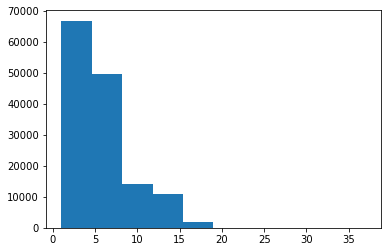

In [60]:
plt.hist(df_after_drop['accommodates'])

(array([2.2560e+03, 2.5032e+04, 0.0000e+00, 3.9624e+04, 3.3792e+04,
        1.5816e+04, 2.4528e+04, 2.7840e+03, 9.6000e+01, 2.4000e+01]),
 array([0.        , 0.36109179, 0.72218358, 1.08327537, 1.44436717,
        1.80545896, 2.16655075, 2.52764254, 2.88873433, 3.24982612,
        3.61091791]),
 <BarContainer object of 10 artists>)

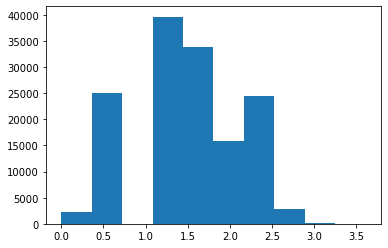

In [61]:
accommodates_logs = np.log(df_after_drop['accommodates'])
mean = np.mean(accommodates_logs, axis=0)
sd = np.std(accommodates_logs, axis=0)
plt.hist(accommodates_logs)

In [62]:
df_after_drop.shape

(143952, 21)

In [63]:
df_after_drop['accommodates_logs'] = np.log(df_after_drop['accommodates'])

In [64]:
from scipy import stats
df_after_drop = df_after_drop[(np.abs(stats.zscore(df_after_drop['accommodates_logs'])) < 2)]
df_after_drop.shape

(141576, 22)

(array([7.5000e+04, 4.6104e+04, 1.8888e+04, 8.4000e+02, 1.9200e+02,
        4.5600e+02, 4.8000e+01, 0.0000e+00, 0.0000e+00, 4.8000e+01]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

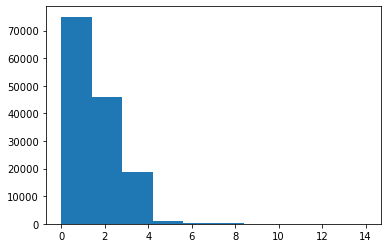

In [65]:
plt.hist(df_after_drop['bathrooms'])

In [66]:
df_after_drop['bathrooms'].head(25)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
Name: bathrooms, dtype: float64

In [67]:
df_after_drop.loc[df_after_drop.bathrooms == 0, 'bathrooms'] = .001

In [68]:
df_after_drop['baths_logs'] = np.log(df_after_drop['bathrooms'])
from scipy import stats
df_after_drop = df_after_drop[(np.abs(stats.zscore(df_after_drop['baths_logs'])) < 2)]
df_after_drop.shape

(139944, 23)

(array([46104., 45456., 25512., 12456.,  6984.,  2568.,   576.,    72.,
           48.,   168.]),
 array([  0. ,  51.5, 103. , 154.5, 206. , 257.5, 309. , 360.5, 412. ,
        463.5, 515. ]),
 <BarContainer object of 10 artists>)

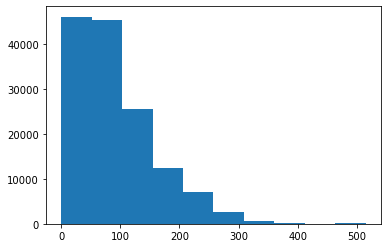

In [69]:
plt.hist(df_after_drop['cleaning_fee'])

In [70]:
df_after_drop.loc[df_after_drop.cleaning_fee == 0].shape

(12336, 23)

In [71]:
mean = df_after_drop['cleaning_fee'].mean()
sd = np.std(df_after_drop['cleaning_fee'])
sd

71.13344618938828

In [72]:
df_after_drop[df_after_drop.cleaning_fee < (3*sd)+mean].shape

(139080, 23)

(array([130704.,   1104.,    336.,    384.,    216.,      0.,      0.,
             0.,      0.,   7200.]),
 array([1.0000e+00, 1.1850e+02, 2.3600e+02, 3.5350e+02, 4.7100e+02,
        5.8850e+02, 7.0600e+02, 8.2350e+02, 9.4100e+02, 1.0585e+03,
        1.1760e+03]),
 <BarContainer object of 10 artists>)

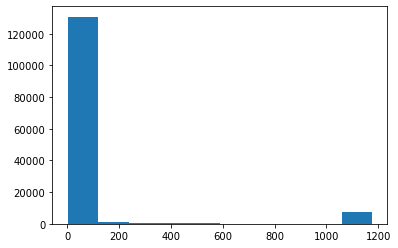

In [73]:
plt.hist(df_after_drop['host_listings_count'])

In [74]:
mean = np.mean(df_after_drop['host_listings_count'])
mean

77.45395300977533

# Now we will run the regressor test again

In [75]:
df_after_drop.drop(columns=['baths_logs', 'accommodates_logs'], inplace = True)

In [76]:
df_after_drop.columns

Index(['id', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'security_deposit', 'cleaning_fee', 'review_scores_rating',
       'number_of_reviews', 'days_host', 'free_parking_on_premises',
       'paid_parking_off_premises', 'elevator', 'gym', 'month', 'price',
       'neighbourhood_cleansed_District 17',
       'neighbourhood_cleansed_District 19', 'room_type_Entire home/apt',
       'property_type_Villa', 'day_weekend'],
      dtype='object')

In [77]:
df_after_drop['id_month'] = df_after_drop['id'].astype(str) + '_' + df_after_drop['month'].astype(str)
df_after_drop.head(10)

,id,host_listings_count,accommodates,bathrooms,bedrooms,security_deposit,cleaning_fee,review_scores_rating,number_of_reviews,days_host,free_parking_on_premises,paid_parking_off_premises,elevator,gym,month,price,neighbourhood_cleansed_District 17,neighbourhood_cleansed_District 19,room_type_Entire home/apt,property_type_Villa,day_weekend,id_month
0,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,1,40.0,0.0,0.0,0.0,0.0,0.0,6422_1
1,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,2,40.0,0.0,0.0,0.0,0.0,0.0,6422_2
2,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,3,40.0,0.0,0.0,0.0,0.0,0.0,6422_3
3,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,4,40.0,0.0,0.0,0.0,0.0,0.0,6422_4
4,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,5,40.0,0.0,0.0,0.0,0.0,0.0,6422_5
5,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,6,40.0,0.0,0.0,0.0,0.0,0.0,6422_6
6,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,7,40.0,0.0,0.0,0.0,0.0,0.0,6422_7
7,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,8,40.0,0.0,0.0,0.0,0.0,0.0,6422_8
8,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,9,40.0,0.0,0.0,0.0,0.0,0.0,6422_9
9,6422,1,2,1.0,2,0.0,0.0,99.0,561,3576,1.0,0.0,0.0,0.0,10,40.0,0.0,0.0,0.0,0.0,0.0,6422_10


In [78]:
df_after_drop['month_day'] = df_after_drop['month'].astype(str) + '_' + df_after_drop['day_weekend'].astype(str)

In [79]:
# Create new df to split without duplicates
df_after_drop_no_dups = df_after_drop.drop_duplicates(subset='id')

In [89]:
#Define the target
y_2 = df_after_drop['price'].values

#Define the features
X_2_columns = df_after_drop.drop(columns =['price','id']).columns
X_2 = df_after_drop.drop(columns =['price','id']).values

In [90]:
df_after_drop['month_day'].head(24)

0      1_0.0
1      2_0.0
2      3_0.0
3      4_0.0
4      5_0.0
5      6_0.0
6      7_0.0
7      8_0.0
8      9_0.0
9     10_0.0
10    11_0.0
11    12_0.0
12     1_1.0
13     2_1.0
14     3_1.0
15     4_1.0
16     5_1.0
17     6_1.0
18     7_1.0
19     8_1.0
20     9_1.0
21    10_1.0
22    11_1.0
23    12_1.0
Name: month_day, dtype: object

In [111]:
from sklearn.model_selection import GroupKFold
# Split the preprocessed data into a training and testing dataset
gkf = GroupKFold(n_splits = 24)
groups = df_after_drop['month_day'].values
for train_index, test_index in gkf.split(X_2, y_2, groups=groups):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]

In [112]:
# Delete the id columns before training and testing
X_train = np.delete(X_train, [19,20], 1)
X_test = np.delete(X_test, [19,20], 1)

In [113]:
# import the regressor 
from sklearn.ensemble import RandomForestRegressor
#Instantiate the Decision Tree Regression model:
random_forest_regression_model2 = RandomForestRegressor(n_estimators = 100, random_state = 78) 
random_forest_regression_model2.fit(X_train, y_train)

RandomForestRegressor(random_state=78)

In [114]:
# Calculate the r-squared score of the initial model.
R_squared_training_set2 = random_forest_regression_model2.score(X_train, y_train, sample_weight=None)
print(f"R-Squared Training Set:  {R_squared_training_set2}")

R_squared_testing_set2 = random_forest_regression_model2.score(X_test, y_test, sample_weight=None)
print(f"R-Squared Testing Set:  {R_squared_testing_set2}")

R-Squared Training Set:  0.994640422753407
R-Squared Testing Set:  0.8711678038474518


In [119]:
X_test.shape

(5831, 19)

In [120]:
X_train.shape

(134113, 19)

In [118]:
# Predict using the Decision Tree Random Forest Regression model.
y_pred = random_forest_regression_model2.predict(X_test)
y_pred.shape

(5831,)

In [116]:
# Calculate the predicted prices for scaled_X using the model.

output = pd.DataFrame({"Prediction":y_pred,"Actual":y_test})
print(output)

0435
5186   154.823020   170.000000
5187   141.044875   153.130435
5188   163.037137   178.695652
5189   156.329801   170.000000
5190   148.925016   161.608696
5191   148.597834   161.608696
5192   147.509562   161.608696
5193   154.022254   170.000000
5194   131.830000   132.000000
5195   120.485380   128.782609
5196   126.180832   128.782609
5197   126.095560   128.782609
5198    89.000000    89.000000
5199    80.000000    80.000000
5200   100.000000   100.000000
5201   125.555353    99.000000
5202    37.000000    37.000000
5203   224.854577   147.000000
5204    60.476190    60.000000
5205    60.000000    60.000000
5206    64.824935    65.000000
5207   127.669474   120.000000
5208    90.300000    90.000000
5209   282.906364   283.000000
5210   121.000000   121.000000
5211   149.866087   150.000000
5212   192.161679   201.000000
5213    83.000000    83.000000
5214    70.023810    70.000000
5215   200.000000   200.000000
5216    85.000000    85.000000
5217    85.000000    85.000000
521

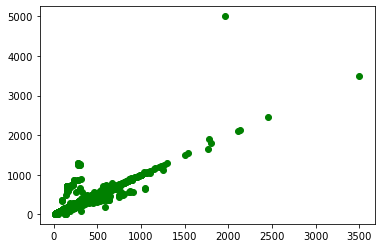

In [117]:
plt.scatter(y_pred, y_test, color='green')

In [121]:
#Calculate the mean squared error
mse2 = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse2}")
rmse2 = np.sqrt(mse2)
print(f"Mean Error: {rmse2}")

Mean Squared Error: 4895.286288148679
Mean Error: 69.96632252840419


In [122]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '$')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors /y_test )

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('% Correct:', round(accuracy, 2), '%.')

Mean Absolute Error: 12.28 $
% Correct: 96.08 %.


In [ ]:
# Create a smaller version of the model for saving
random_forest_regression_model_small = RandomForestRegressor(n_estimators = 64, max_depth=32, random_state = 78) 
random_forest_regression_model_small.fit(X_train, y_train)

In [ ]:
# Save the model using pickle
import pickle
filename = 'rfr_model_post_feat_sel.pickle'
with open(filename, 'wb') as file:
    pickle.dump(random_forest_regression_model_small, file)

In [ ]:
# Test opening saved model and run prediction
import pickle
filename = 'rfr_model_post_feat_sel.pickle'
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
df_after_drop.columns

In [ ]:
X_test.head()

In [ ]:
X_test_pickle = [76,4,2,2,218,103,97,47,1199,1,0,0,0,0,0,0,0,0,1,0,0]
X_test_pickle = np.array(X_test_pickle)
X_test_pickle = X_test_pickle.reshape(1,-1)

In [ ]:
#  try a test on the model with made up data
y_pred_pickle = pickle_model.predict(X_test_pickle)
y_pred_pickle
# pickle_results_df = pd.DataFrame({"Prediction":y_pred_pickle,"Actual":y_test})
# results_df = pickle_results_df.merge(X_test2,left_index=True,right_index=True )
# results_df.to_csv('Resources/results_df.csv')

In [ ]:
results_df

In [ ]:
df_after_drop.head(10)

In [ ]:
# Create new model for testing with top continuous variables only
df_cont_only = df_after_drop[['accommodates', 'bathrooms', 'bedrooms','security_deposit','cleaning_fee','price']].copy()
df_cont_only.head(10)

In [ ]:
#Define the target
y_3 = df_cont_only['price']

#Define the features
X_3 = df_cont_only.drop(columns ='price')

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, random_state=78)

In [ ]:
random_forest_regression_model_test = RandomForestRegressor(n_estimators = 64, max_depth=32, random_state = 78) 
random_forest_regression_model_test.fit(X_train3, y_train3)

In [ ]:
# Predict using the Decision Tree Random Forest Regression model.
y_pred3 = random_forest_regression_model_test.predict(X_test3)
# Calculate the absolute errors
errors = abs(y_pred3 - y_test3)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '$')

In [ ]:
pd.pandas.set_option('display.max_columns', 100)
pd.pandas.set_option('display.max_rows', 100)


In [ ]:
y_pred3

In [ ]:
y_pred3_df = pd.DataFrame(y_pred3.values, columns = ['pred_price'], index = X_test3.index)
y_pred3_df

In [ ]:
results_df = pd.DataFrame(y_test3)
results_df.join(y_pred3_df)

In [ ]:
# Save the model using pickle
import pickle
filename = 'rfr_model_post_feat_sel.pickle'
with open(filename, 'wb') as file:
    pickle.dump(random_forest_regression_model_test, file)